In [18]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [19]:
#download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/gOwG6DKD7IpkPze')

In [20]:
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

In [21]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

In [22]:
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T

In [23]:
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   

100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:20<00:00, 246.96it/s]


# Exercise 1

## A. 
For the original calculation all the data points (5027) are used for calculating the position of the mouse from the cell activity. To see how this number of data points influences the median error, a fraction of the data points is taken randomly. This is done in 10 steps data points. 

Below the median error is plot against the number of data points used. As expected, by the lowest amount of data points the median error is the largest. However, the median error is not lowest when all data points are used, but is optimal when 3500 data points are used. The decoded location of the mouse is obtained by fitting the spike data to all possible locations. If too many data points are used, there will be overfitting, resulting in a higher median error. 

In [4]:
data_points = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5027]
mse = np.zeros(len(data_points))

for i in range(len(data_points)):
    #first make an array of # unique elements that correspons with positions in a list (0 to 5026)
    data_positions = []
    while len(data_positions)<data_points[i]:
        number = np.random.choice(np.linspace(0,5026,5027))
        if number not in data_positions:
            data_positions.append(number)
    data_positions = np.sort(data_positions) 
    
    x,t = data['x'],data['t']
    #take randomly (determined by data_position array) fraction of the data points of x and t
    new_x = np.zeros(data_points[i])
    new_t = np.zeros(data_points[i])
    num = 0
    for k in range(data_points[i]):
        for j in range(5027):
            if data_positions[k] == j:
                new_x[num] = x[j]
                new_t[num] = t[j]
                num += 1
    x = new_x
    t = new_t
    
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape
    
    # code decoding

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for k in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[k] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,k]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   
    mse[i] = np.nanmedian(np.sqrt((true_x-x_decoded)**2))


100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:24<00:00, 201.31it/s]


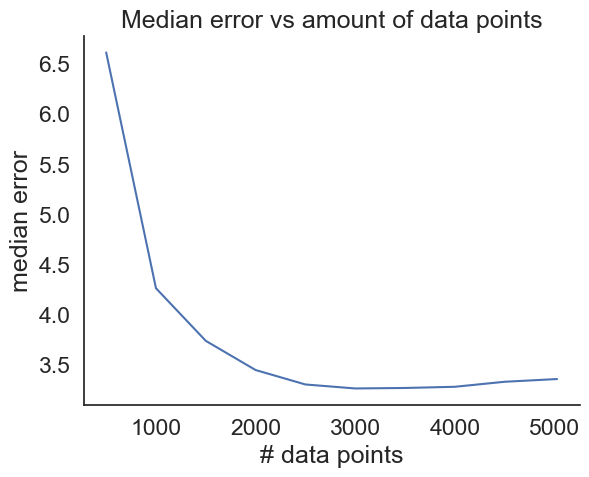

[6.61111111 4.26190476 3.73777778 3.44701426 3.30308457 3.2634291
 3.26817043 3.28       3.32994845 3.357155  ]


In [5]:
plt.plot(data_points, mse)
plt.xlabel('# data points')
plt.ylabel('median error')
plt.title('Median error vs amount of data points')
plt.show()

print(mse)

## B. 
The dependence of the median error on the number of place cells is given in the plot below. The value of the median error is decreasing as the number of place cells is decreasing, but it is decreasing less and less, reaching an asymptote. From this plot it looks like using all 100 place cell recordings results in the lowest median error. Using more place cells will maybe result in an even less median error, but the improvement will not be that much (since it looks like reaching an asymptote). 

In [6]:
num_cells = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
mse = np.zeros(len(num_cells))
x,t,spikes = data['x'],data['t'],data['spikes']

for i in range(len(num_cells)):
    data_positions = []
    while len(data_positions)<num_cells[i]:
        number = np.random.choice(np.linspace(0,99,100))
        if number not in data_positions:
            data_positions.append(number)
    data_positions = np.sort(data_positions)

    spikes = data['spikes']
    
    # we compute the poistion at which each spike was emitted
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape
    
    # select # of neurons from the firing rate maps and spikes count
    new_frm = np.zeros([num_cells[i], 39])
    for k in range(len(data_positions)):
        data_position = int(data_positions[k])
        new_frm[k,:] = firing_rate_maps[data_position,:]
    firing_rate_maps = new_frm
    
    new_spikes = np.zeros([5026,num_cells[i]])
    for k in range(len(data_positions)):
        data_position = int(data_positions[k])
        new_spikes[:,k] = spikes_count[:,data_position]
    spikes_count = new_spikes
    
    # code decoding
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for k in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[k] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,k]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   
    mse[i] = np.nanmedian(np.sqrt((true_x-x_decoded)**2))


100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:21<00:00, 232.27it/s]


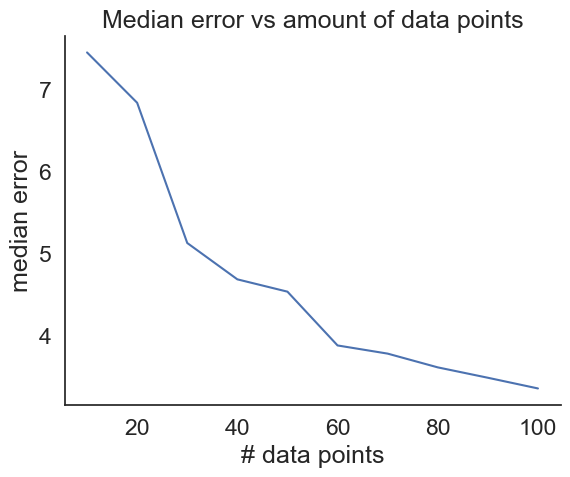

[7.45159414 6.83838384 5.12948509 4.68671679 4.5365873  3.88117647
 3.7816092  3.61403509 3.48753463 3.357155  ]


In [7]:
plt.plot(num_cells, mse)
plt.xlabel('# data points')
plt.ylabel('median error')
plt.title('Median error vs amount of data points')
plt.show()

print(mse)

## C. 

You would expect by increasing the noise in the firing rates, there exists more noise the timing of the spikes at a location x. As a consequence it is harder to reconstruct the path 'x_decoded' with this noise spike pattern. Therefore the median error will increase by increasing the noise. This is exactly what we see in the plot below. 

In [15]:
noise_firing_rates = np.array([0.01,0.1,1,3,5,10]) # the baseline noise firing rate
mse = np.zeros(len(noise_firing_rates))

for i in range(len(noise_firing_rates)):
    noise_firing_rate = noise_firing_rates[i]
    spikes = []
    for idx in range(n_cells):
        inst_rate = true_firing_rate_maps[idx,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape
    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)
    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
            for j in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[j] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,j]/fps)+pow(1,-15))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan   
    mse[i] = np.nanmedian(np.sqrt((true_x-x_decoded)**2))

100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:27<00:00, 183.72it/s]


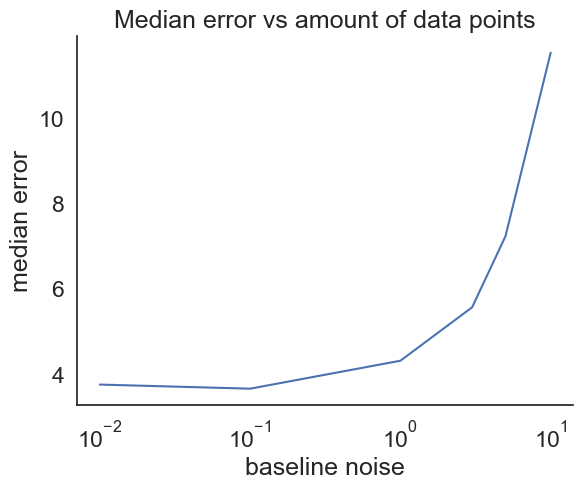

[ 3.76294996  3.66666667  4.32070707  5.57071429  7.23307252 11.5301005 ]


In [16]:
plt.plot(noise_firing_rates, mse)
plt.xlabel('baseline noise')
plt.ylabel('median error')
plt.title('Median error vs amount of data points')
plt.xscale('log')
plt.show()

print(mse)

# Exercise 2
Below, the histograms and median error are shown for both posterior calculation methods. For the original method, the median error is twice as small as for the new calculation. You can see that for the original calculation method, most of the error counts are located between 0 and 20 cm, while for the new calculation method there is a significant amount of counts higher than 30 cm. 

By using the original method, the log is taken from the probability mass function of the poisson distribution before calculating the posterior, while in the new method, first the values of the probability mass function are calculated, and after that with the logarithm the posterior. So with the first method, you substitute values of $\mu$ and $k$ (spikes_count[t_bin,:] and firing_rate_maps[:,i]/fps respectively) into:
\begin{equation}
    PMF = -\mu +k \log(\mu) -log(k!)
\end{equation}
While using the new method, you are substituting values of $\mu$ and $k$ into:
\begin{equation}
 PMF = \log(\exp(-\mu)\frac{\mu^k}{k!})
\end{equation}
where you thus first calculate a value, and then take the logarithm while in the first equation you enter values into a logarithm. So in the original method, you add the values to get the posterior, while in the new method you multiply the values, and then take the logaritm. The error becomes bigger with multiplying than adding, resulting in a higher median when the new method is used.  


100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:15<00:00, 325.09it/s]


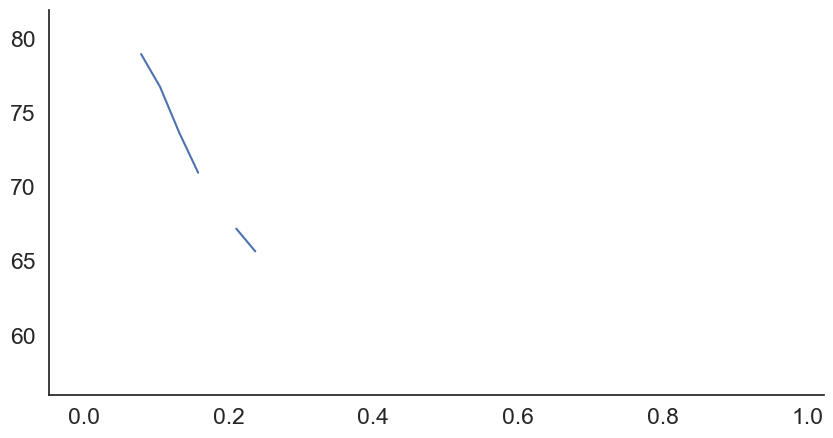

100%|█████████████████████████████████████████████████████████████████████████████| 5026/5026 [00:20<00:00, 250.37it/s]


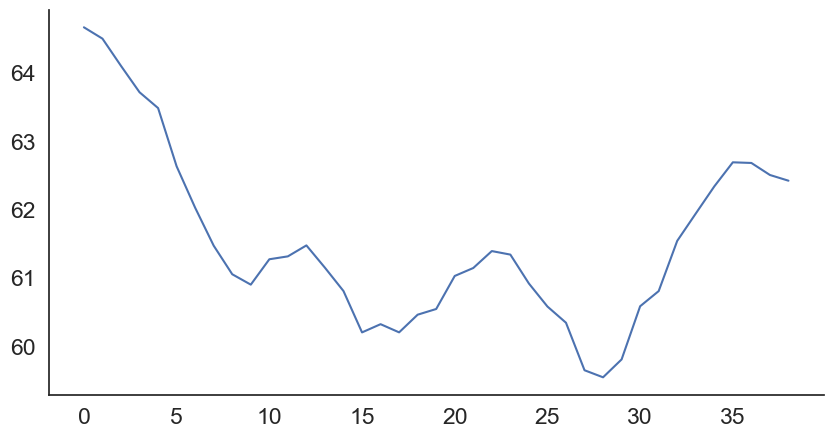

In [12]:
x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

mse = np.zeros([5026,2])
x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan
plt.plot(np.linspace(0,1,len(posterior)),posterior)
plt.show()
mse[:,0] = np.sqrt((true_x-x_decoded)**2)
x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            #posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan 
plt.plot(posterior)
plt.show()
mse[:,1] = np.sqrt((true_x-x_decoded)**2)


Median error original calculation: 3.357155002380459 cm
Mean error original calculation: 4.8679440455887635 cm
Median error new calculation: 6.407201828099659 cm
Mean error original calculation: 21.297856766479338 cm


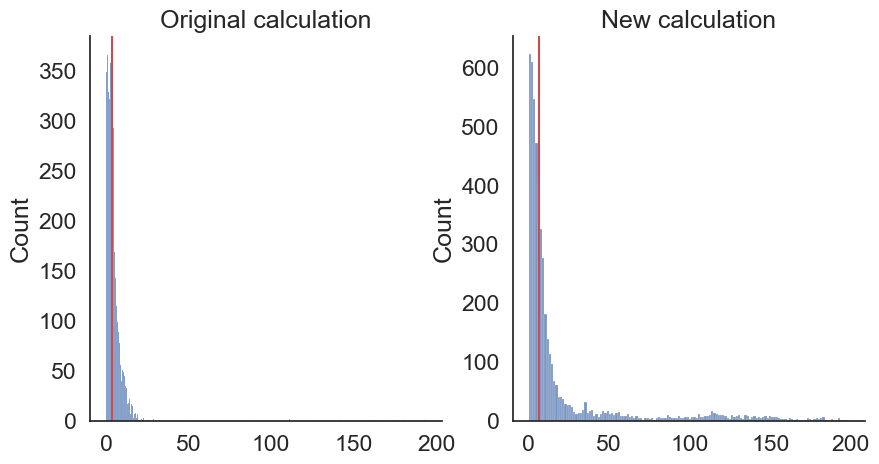

In [13]:
plt.subplot(1,2,1)
sns.histplot(mse[:,0])
plt.axvline(x = np.nanmedian(mse[:,0]),c='r')
plt.title('Original calculation')
print(f'Median error original calculation: {np.nanmedian(mse[:,0])} cm')
print(f'Mean error original calculation: {np.nanmean(mse[:,0])} cm')
plt.subplot(1,2,2)
sns.histplot(mse[:,1])
plt.title('New calculation')
plt.axvline(x = np.nanmedian(mse[:,1]),c='r')
print(f'Median error new calculation: {np.nanmedian(mse[:,1])} cm')
print(f'Mean error original calculation: {np.nanmean(mse[:,1])} cm')
plt.show()

# Exercise 3

## A. 
A false negative is when a real sequences is not seen as significantly relevent, and a false positive is when a random sequences is seen as significantly relevent. So what you would expect with a good sequence detection method is that the values of false negatives and positive is low, such that most real sequences are seen as significant, while most random sequences are not. 

In [24]:
n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1

In [25]:
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

In [26]:
# to do: bayesian decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
        reactivation_pvalues[event] = corr[1]


In [27]:
#false positive if one of the random sequences (100 to 199) are within the threshold alpha
#false negative if one of the correlated sequences (0 to 99) are outside the threshold alpha
alpha = 0.05
False_negative = 0
False_positive = 0

for i in range(len(reactivation_pvalues)):
    if i < 100:
        if reactivation_pvalues[i] > alpha:
            False_negative += 1
    else:
        if reactivation_pvalues[i] < alpha:
            False_positive +=1             
print('False negatives:',+False_negative)
print('False positives:',+False_positive)

False negatives: 92
False positives: 8


## B. 

To see the influence of the variables noise_x_react and noise_t_react, one of the two variables is set to 0.01 when the other is varied over a range of values. 

You would expect by increasing the noise values that the number of false negatives increases in both cases. The variable noise_x_react only plays a role by the real sequences, therefore you don't expect a change in false positives while varying over noise_x_react. The variable noise_t_react plays a role in both false positives and negatives. But because the random sequences are already random, the influence is non significant. So also here you would expect that the value of false negatives increases with the increase of noise_t_react. 

In the plots below however, we don't really see what we expect. The values of false positives is indeed low, but goes to zero as the two variables are increased, which is strange since the variables have no (significant) influence on the calculation. And the value of false negatives does increase a little, but the decreases for the increase of the variables. Also the shape of the curve is very much identical in both cases. 

I think there is something wrong with my code, but I can't figure out what it is. The fact that both shapes are identical (with the values somewhat varied) is also a bit suspicious. Also if I put the other variable to a different constant (for example 5), the shape and values stays the same. However, after many hours, I did not manage to find what is going wrong here.  






#### Investigate noise_x_react

In [43]:
# generate data 

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
alpha = 0.05
noise_x_react_values=[0.1,0.5,1,5,10,15,20]; # Noise in the reactivation of the sequence
noise_t_react=0.01; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate
time_window = 10 # number of bins to aggregate during decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding
reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))
False_positive = np.zeros(len(noise_x_react_values))
False_negative = np.zeros(len(noise_x_react_values))


for k in range(len(noise_x_react_values)):
    noise_x_react = noise_x_react_values[k]
    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration)+np.random.normal(0,noise_x_react,size=event_duration)
        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);
        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length
        reactivation_events[event,:] = x_react
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1
    reactivation_slope = np.zeros(n_events)
    for event in range(n_events):
        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)
    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)
    for event in range(n_events):
        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)
        x_decoded = np.zeros(spikes_sampled.shape[1])
        for t_bin in range(spikes_sampled.shape[1]):
            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))
                x_decoded[t_bin] = space_bins[np.argmax(posterior)]
            else:
                x_decoded[t_bin] = np.nan   
            #idx = np.isfinite(x_decoded)
            #slope,_ = np.polyfit(np.arange(len(x_decoded[idx])),x_decoded[idx],deg=1)
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            # corr = pearsonr(np.arange(len(x_decoded[idx])),x_decoded[idx])
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]
    for i in range(len(reactivation_pvalues)):
        if i < 100:
            if reactivation_pvalues[i] > alpha:
                False_negative[k] += 1
        else:
            if reactivation_pvalues[i] < alpha:
                False_positive[k] +=1 

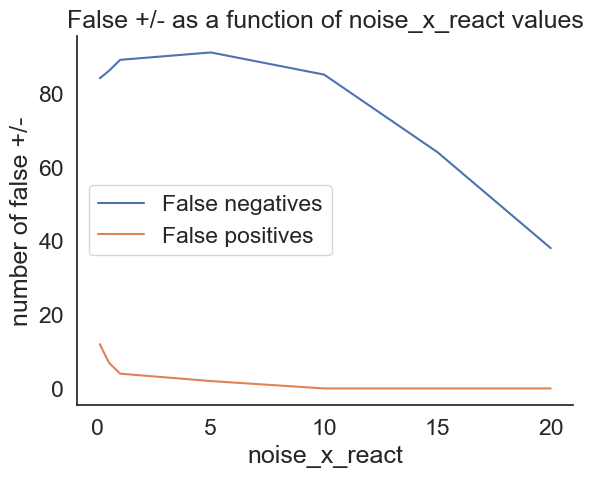

False negative values: [84. 86. 89. 91. 85. 64. 38.]
False positives values: [12.  7.  4.  2.  0.  0.  0.]


In [44]:
plt.title('False +/- as a function of noise_x_react values')
plt.plot(noise_x_react_values, False_negative, label='False negatives')
plt.plot(noise_x_react_values, False_positive, label='False positives')
plt.xlabel('noise_x_react')
plt.ylabel('number of false +/-')
plt.legend()
plt.show()

print("False negative values:",+False_negative)
print('False positives values:',+False_positive)

#### Investigate noise_t_react

In [45]:
noise_t_react_values=[0.1,0.5,1,5,10,15,20]; # Noise in the reactivation of the sequence
noise_x_react=0.01; # Noise in the timing of the spikes 
reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))
False_positive = np.zeros(len(noise_t_react_values))
False_negative = np.zeros(len(noise_t_react_values))

for k in range(len(noise_t_react_values)):
    noise_t_react = noise_t_react_values[k]
    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration)+np.random.normal(0,noise_x_react,size=event_duration)
        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);
        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length
        reactivation_events[event,:] = x_react
        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1
    reactivation_slope = np.zeros(n_events)
    for event in range(n_events):
        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)
    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)
    for event in range(n_events):
        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)
        x_decoded = np.zeros(spikes_sampled.shape[1])
        for t_bin in range(spikes_sampled.shape[1]):
            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))
                x_decoded[t_bin] = space_bins[np.argmax(posterior)]
            else:
                x_decoded[t_bin] = np.nan   
            #idx = np.isfinite(x_decoded)
            #slope,_ = np.polyfit(np.arange(len(x_decoded[idx])),x_decoded[idx],deg=1)
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            # corr = pearsonr(np.arange(len(x_decoded[idx])),x_decoded[idx])
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]
    for i in range(len(reactivation_pvalues)):
        if i < 100:
            if reactivation_pvalues[i] > alpha:
                False_negative[k] += 1
        else:
            if reactivation_pvalues[i] < alpha:
                False_positive[k] +=1 

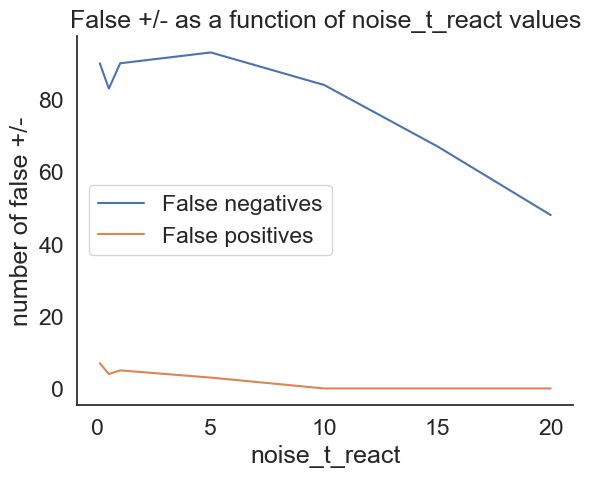

False negative values: [90. 83. 90. 93. 84. 67. 48.]
False positives values: [7. 4. 5. 3. 0. 0. 0.]


In [46]:
plt.title('False +/- as a function of noise_t_react values')
plt.plot(noise_t_react_values, False_negative, label='False negatives')
plt.plot(noise_t_react_values, False_positive, label='False positives')
plt.xlabel('noise_t_react')
plt.ylabel('number of false +/-')
plt.legend()
plt.show()

print("False negative values:",+False_negative)
print('False positives values:',+False_positive)

## C. 

Even when all the noise is set to 0, the detection method still misses real sequence events (false negative is non zero). This can be due to the time window that is used for the decoding. By taking a smaller time window, faster sequences can also be detected. So to improve the detection method this variable could be varied. 

Also, in this experiment a straight line is used, but when a different trajectory is used, the fit that is done has to be different. This could give problems by detecting the real sequences. 